# Aplicando PCA sobre RandomForest

En este JN, voy a aplicarle un PCA para saber si puedo mejorar mi modelo de alguna forma.

Al final, en la sección de Conclusiones, valoraré si finalmente le aplico a mi modelo PCA o no.

*Cada vez que aplico un PCA vuelvo a importar las librerías y a cargar el datasaset dado que si no lo hago me da error al calcular determinados scores o coeficientes.

Empiezo importando las librerías que voy a utilizar y cargando mi dataset.

In [93]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas.io

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy import interp

from itertools import cycle

import seaborn as sns

import pickle

In [94]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    theDataFrame = theDataFrame.drop(['Fourier18', 'Fourier19', 'Fourier20', 'Fourier21', 'Fourier22', 'Fourier23', 
                                      'Fourier24', 'Fourier25', 'Fourier26', 'Fourier27', 'Fourier28', 'Fourier29', 
                                      'Fourier30', 'Fourier31', 'Fourier32'], axis=1)
    return theDataFrame

data = readCsvToDataFrame('data_fourier.csv')

In [95]:
data.shape

(14309, 25)

# PCA - 20

Empiezo probando a reducir el número de features de mi modelo a 20, para obtener las diferentes métricas que he obtenido antes, y ver si mejoran sustancialmente mis resultados.

Empiezo escalando las diferentes features que tengo para podemos aplicarle el PCA.

In [96]:
features = ['mfcc', 'scem','scom', 'srom','sbwm', 'tempo', 'rmse', 
            'Fourier1', 'Fourier2', 'Fourier3', 'Fourier4', 'Fourier5', 
            'Fourier6', 'Fourier7', 'Fourier8', 'Fourier9', 'Fourier10',
            'Fourier11', 'Fourier12', 'Fourier13', 'Fourier14', 'Fourier15',
            'Fourier16', 'Fourier17']

x = data.loc[:, features].values
y = data.loc[:,['momento']].values

x = StandardScaler().fit_transform(x)

A continuación le aplico el PCA, reduciendo las features de 39 a 20, y muestro el dataset resultante.

In [97]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4',
                                      'principal component 5',
                                      'principal component 6',
                                      'principal component 7',
                                      'principal component 8',
                                      'principal component 9',
                                      'principal component 10',
                                      'principal component 11',
                                      'principal component 12',
                                      'principal component 13',
                                      'principal component 14',
                                      'principal component 15',
                                      'principal component 16',
                                      'principal component 17',
                                      'principal component 18',
                                      'principal component 19',
                                      'principal component 20'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20
0,-2.201574,-1.257221,-2.003310,-0.393259,1.422131,0.573131,-0.504157,1.556424,0.364251,0.783059,-0.248229,-0.141563,0.011075,-0.009533,-0.114522,-0.180999,0.073954,0.239074,0.002957,0.104563
1,-1.000824,1.353947,-0.411674,0.099155,1.029738,-0.447507,-0.314428,-0.089169,0.560926,0.351522,0.313442,-0.611108,0.044362,-0.062846,0.505463,-0.773850,-0.144078,0.583100,0.002011,-0.223500
2,2.765063,-3.227859,1.140884,0.154238,-1.215644,-0.154076,-1.418689,-0.823201,-0.093776,0.284526,0.705372,0.751297,0.565604,-0.688456,0.535412,0.201567,-0.120738,-0.921069,0.048246,-0.723740
3,2.829244,1.997799,-0.732320,0.232380,-0.852790,-0.144327,0.585869,0.473961,-0.430937,-0.731575,0.814460,0.003058,0.521841,0.658225,-0.146716,0.082917,0.321180,-0.121492,0.276106,-0.803289
4,0.195324,-2.737980,0.874594,-0.613743,-0.622019,0.152145,-0.026323,-0.128407,-0.259658,-0.239129,-0.319676,-0.222016,0.240695,0.585634,-0.379139,-0.245088,0.086033,0.014476,0.128287,0.121883


Y ahora, para poder trabajar y concatenar la X y la y de forma correcta y que no me de errores, reseteo los índices de ambos dataframes.

In [98]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,momento
0,-2.201574,-1.257221,-2.003310,-0.393259,1.422131,0.573131,-0.504157,1.556424,0.364251,0.783059,...,-0.141563,0.011075,-0.009533,-0.114522,-0.180999,0.073954,0.239074,0.002957,0.104563,Timbre
1,-1.000824,1.353947,-0.411674,0.099155,1.029738,-0.447507,-0.314428,-0.089169,0.560926,0.351522,...,-0.611108,0.044362,-0.062846,0.505463,-0.773850,-0.144078,0.583100,0.002011,-0.223500,Cena
2,2.765063,-3.227859,1.140884,0.154238,-1.215644,-0.154076,-1.418689,-0.823201,-0.093776,0.284526,...,0.751297,0.565604,-0.688456,0.535412,0.201567,-0.120738,-0.921069,0.048246,-0.723740,Lavadora
3,2.829244,1.997799,-0.732320,0.232380,-0.852790,-0.144327,0.585869,0.473961,-0.430937,-0.731575,...,0.003058,0.521841,0.658225,-0.146716,0.082917,0.321180,-0.121492,0.276106,-0.803289,Secador_pelo
4,0.195324,-2.737980,0.874594,-0.613743,-0.622019,0.152145,-0.026323,-0.128407,-0.259658,-0.239129,...,-0.222016,0.240695,0.585634,-0.379139,-0.245088,0.086033,0.014476,0.128287,0.121883,Aire_acondicionado


Debido a la reducción de features al aplicar el CA, parte de la totalidad de la variación explicada del modelo original se pierde, por lo que voy a ver cómo se distribuye esta variación entre las 20 features, cuánta variación se explica y cuánta se ha perdido.

In [99]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.37255227 0.17250664 0.06712252 0.04584992 0.04115398 0.03485593
 0.03290361 0.02988563 0.02495122 0.01941069 0.01829993 0.01774286
 0.01745925 0.01534691 0.01333705 0.01230876 0.01185452 0.01114438
 0.01022214 0.00976104] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 97.87%.
La variación perdida con respecto al modelo original ha sido del 2.13%.


Como se puede observar debajo, la correlación entre las diferentes features prácticamente ha desaparecido.

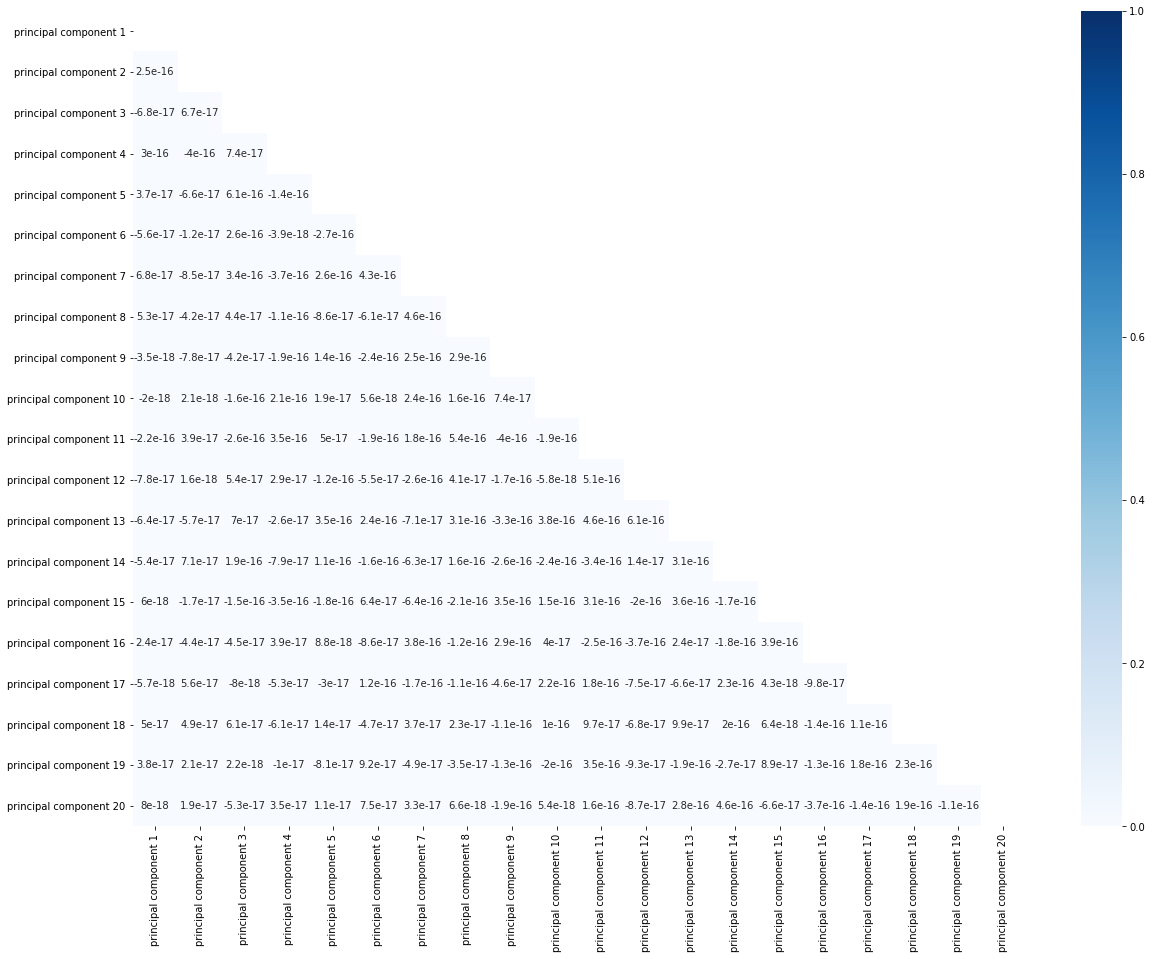

In [100]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,15))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

#     sns.set(style="ticks")
#     sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento')

Y termino con el mismo análisis que hice con el modelo original.

Es por ello que noy voy a entrar a dar epxlicaciones ni para este modelo ni para el resto de PCA, dado que las voy a dar todas juntas en la sección final de Conclusiones de este JN.

In [101]:
y = pd.get_dummies(data=finalDf.momento)
X = data.loc[:, finalDf.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [102]:
clf1 = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(clf1, X, y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.97624039 0.97554158 0.98113208 0.97833683 0.96715584 0.98043326
 0.97484277 0.97344514 0.97624039 0.97202797]
Accuracy: 0.98 (+/- 0.01)


In [103]:
clf1.fit(X_train, y_train)
clf1.score(X_test, y_test)

0.9713487071977638

In [104]:
predictions = clf1.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Alarma                0.00
Aspiradora            0.00
Cena                  0.00
Ducha                 0.00
Grifo                 0.00
Lavadora              0.00
Licuadora             0.01
Microondas            0.00
Secador_pelo          0.00
Secadora              0.00
Silencio              0.00
Tecleo                0.00
Telefono              0.00
Timbre                0.00
dtype: float64 degrees.


In [105]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [106]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [107]:
indices = np.argsort(importances)[::-1]

In [108]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.161374)
2. feature 1 (0.153585)
3. feature 0 (0.144909)
4. feature 4 (0.122154)
5. feature 6 (0.103224)
6. feature 3 (0.100086)
7. feature 10 (0.027709)
8. feature 13 (0.026198)
9. feature 8 (0.020825)
10. feature 9 (0.019652)
11. feature 14 (0.019025)
12. feature 11 (0.016209)
13. feature 15 (0.013386)
14. feature 17 (0.012492)
15. feature 7 (0.011683)
16. feature 19 (0.010575)
17. feature 12 (0.010348)
18. feature 16 (0.009184)
19. feature 5 (0.009038)
20. feature 18 (0.008344)


,importance
scom,0.161374
scem,0.153585
mfcc,0.144909
sbwm,0.122154
rmse,0.103224
srom,0.100086
Fourier4,0.027709
Fourier7,0.026198
Fourier2,0.020825
Fourier3,0.019652


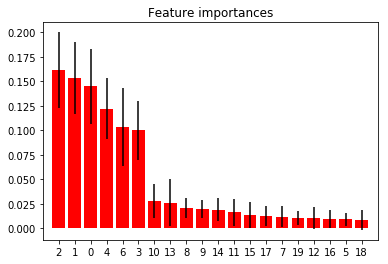

In [109]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [110]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf1.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.972396925227114

In [111]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9727175085796343

In [112]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.714859,1.000000,0.833724
Ducha,1.000000,0.983146,0.991501
Lavadora,1.000000,0.993827,0.996904
Aspiradora,1.000000,0.960674,0.979943
Afeitadora,0.984615,0.948148,0.966038
Secador_pelo,1.000000,0.972527,0.986072
Aire_acondicionado,1.000000,0.966102,0.982759
Telefono,0.987854,0.987854,0.987854
Tecleo,1.000000,0.882075,0.937343


Confusion matrix, without normalization
[[178   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 175   0   0   0   0   0   2   0   0   0   0   0   0   0   0]
 [  1   0 161   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  7   0   0 171   0   0   0   0   0   0   0   0   0   0   0   0]
 [  7   0   0   0 128   0   0   0   0   0   0   0   0   0   0   0]
 [  4   0   0   0   1 177   0   0   0   0   0   0   0   0   0   0]
 [  6   0   0   0   0   0 171   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0 244   0   0   0   0   0   0   0   0]
 [ 22   0   0   0   0   0   0   0 187   2   0   0   0   1   0   0]
 [  2   0   0   0   0   0   0   0   0 183   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0 172   0   0   0   0   0]
 [  3   0   0   0   0   0   0   1   0   0   0 193   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 186   0   0   0]
 [  1   0   0   0   1   0   0   0   0   0   0   0   0 179   0   0]
 [  3   0   0   0   0 

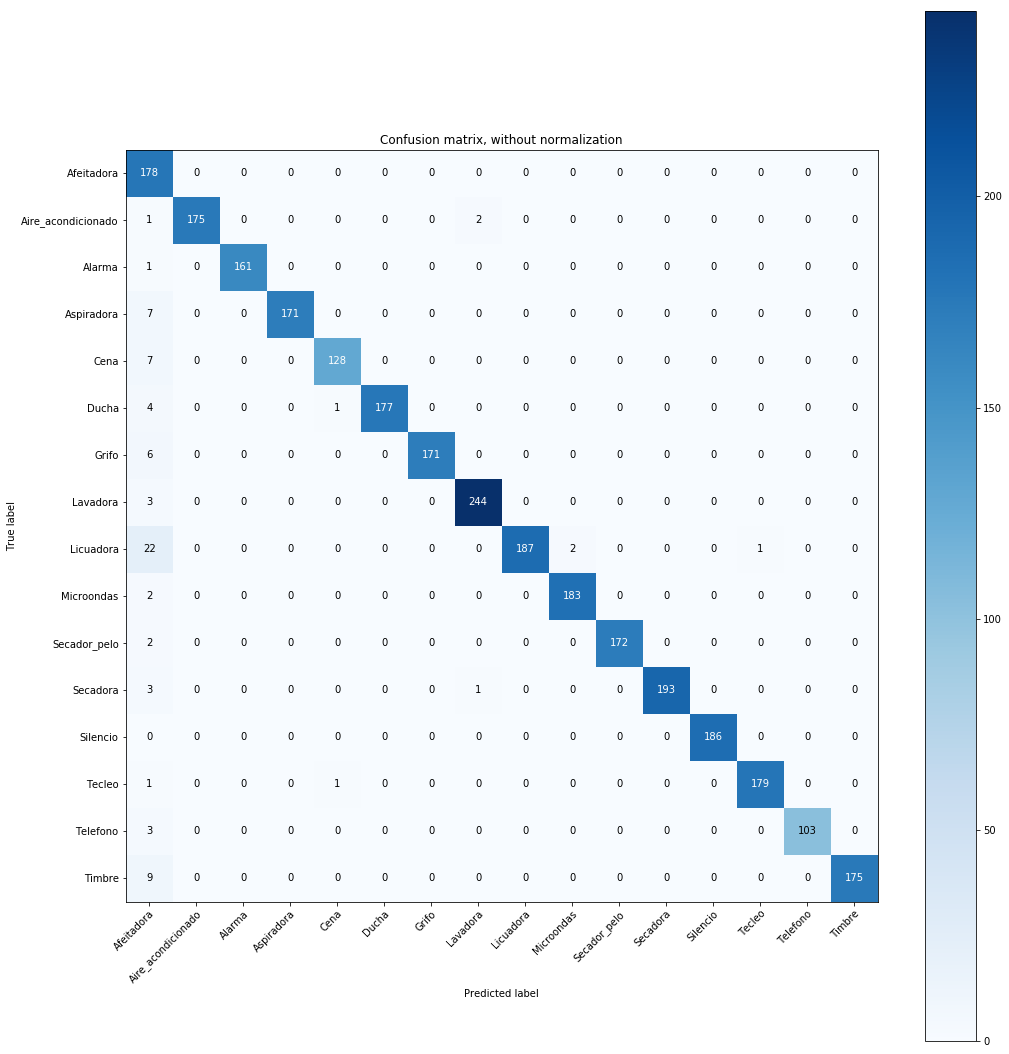

In [113]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [114]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [116]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [117]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [118]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [119]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [120]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [121]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

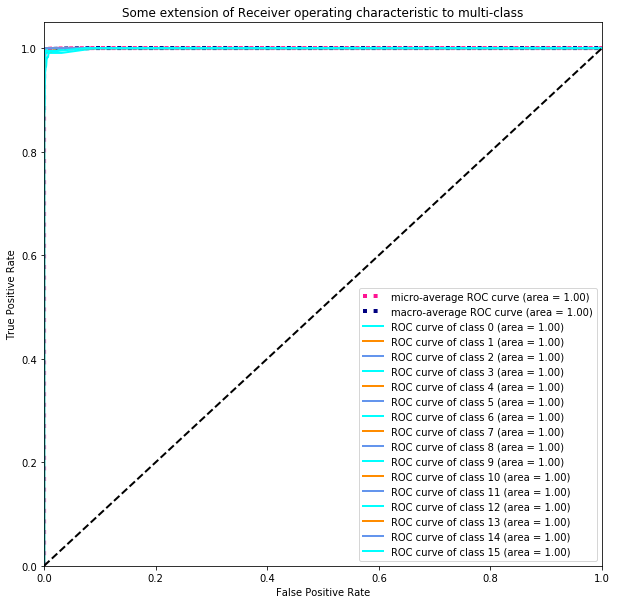

In [122]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# PCA - 10

In [126]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [127]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    theDataFrame = theDataFrame.drop(['Fourier18', 'Fourier19', 'Fourier20', 'Fourier21', 'Fourier22', 'Fourier23', 
                                      'Fourier24', 'Fourier25', 'Fourier26', 'Fourier27', 'Fourier28', 'Fourier29', 
                                      'Fourier30', 'Fourier31', 'Fourier32'], axis=1)
    return theDataFrame

data = readCsvToDataFrame('data_fourier.csv')

In [128]:
features = ['mfcc', 'scem','scom', 'srom','sbwm', 'tempo', 'rmse', 
            'Fourier1', 'Fourier2', 'Fourier3', 'Fourier4', 'Fourier5', 
            'Fourier6', 'Fourier7', 'Fourier8', 'Fourier9', 'Fourier10',
            'Fourier11', 'Fourier12', 'Fourier13', 'Fourier14', 'Fourier15',
            'Fourier16', 'Fourier17',]

x = data.loc[:, features].values
y = data.loc[:,['momento']].values

x = StandardScaler().fit_transform(x)

In [129]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4',
                                      'principal component 5',
                                      'principal component 6',
                                      'principal component 7',
                                      'principal component 8',
                                      'principal component 9',
                                      'principal component 10'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,-2.201575,-1.257221,-2.003280,-0.393280,1.422458,0.573612,-0.503351,1.555657,0.364816,0.782087
1,-1.000824,1.353947,-0.411689,0.098984,1.029689,-0.447734,-0.315150,-0.088995,0.561740,0.345871
2,2.765064,-3.227856,1.140659,0.154261,-1.217274,-0.156020,-1.422921,-0.817646,-0.095733,0.282606
3,2.829244,1.997803,-0.732596,0.232218,-0.854924,-0.147250,0.579933,0.480690,-0.432892,-0.738830
4,0.195324,-2.737978,0.874487,-0.613767,-0.622226,0.152103,-0.027609,-0.125927,-0.259149,-0.245660


In [130]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,momento
0,-2.201575,-1.257221,-2.003280,-0.393280,1.422458,0.573612,-0.503351,1.555657,0.364816,0.782087,Timbre
1,-1.000824,1.353947,-0.411689,0.098984,1.029689,-0.447734,-0.315150,-0.088995,0.561740,0.345871,Cena
2,2.765064,-3.227856,1.140659,0.154261,-1.217274,-0.156020,-1.422921,-0.817646,-0.095733,0.282606,Lavadora
3,2.829244,1.997803,-0.732596,0.232218,-0.854924,-0.147250,0.579933,0.480690,-0.432892,-0.738830,Secador_pelo
4,0.195324,-2.737978,0.874487,-0.613767,-0.622226,0.152103,-0.027609,-0.125927,-0.259149,-0.245660,Aire_acondicionado


In [131]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.37255227 0.17250664 0.06712252 0.04584992 0.04115394 0.03485587
 0.03290341 0.02988536 0.02495115 0.01941025] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 84.12%.
La variación perdida con respecto al modelo original ha sido del 15.88%.


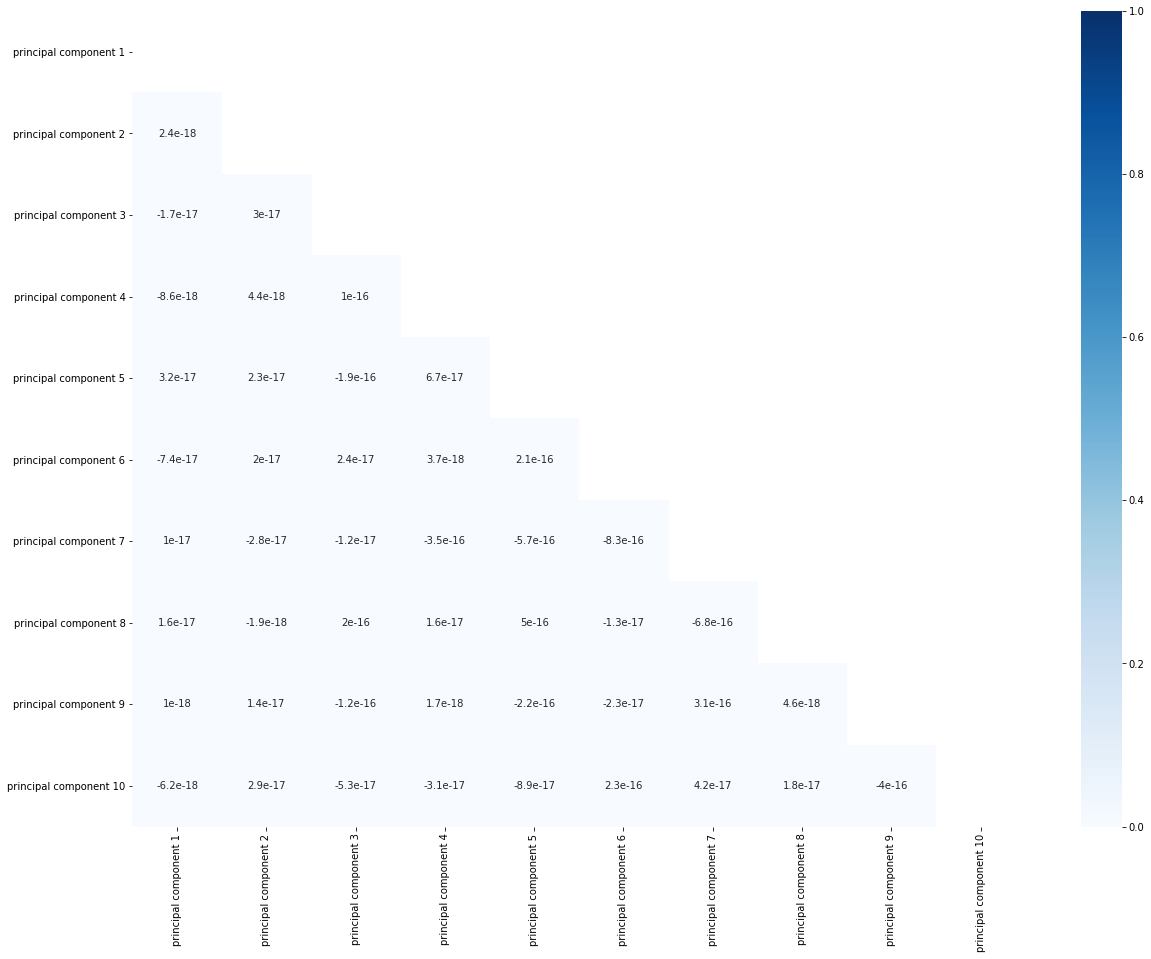

In [132]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,15))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

#     sns.set(style="ticks")
#     sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento')

In [133]:
y = pd.get_dummies(data=finalDf.momento)
X = data.loc[:, finalDf.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [134]:
clf2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(clf2, X, y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.9881202  0.98462614 0.99091544 0.98532495 0.98322851 0.99161426
 0.98392732 0.98462614 0.98322851 0.98181818]
Accuracy: 0.99 (+/- 0.01)


In [135]:
clf2.fit(X_train, y_train)
clf2.score(X_test, y_test)

0.9874213836477987

In [136]:
filename = 'finalized_model_fourier_32_PCA.sav'
pickle.dump(clf2, open(filename, 'wb'))

In [137]:
predictions = clf2.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.0
Aire_acondicionado    0.0
Alarma                0.0
Aspiradora            0.0
Cena                  0.0
Ducha                 0.0
Grifo                 0.0
Lavadora              0.0
Licuadora             0.0
Microondas            0.0
Secador_pelo          0.0
Secadora              0.0
Silencio              0.0
Tecleo                0.0
Telefono              0.0
Timbre                0.0
dtype: float64 degrees.


In [138]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [139]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [140]:
indices = np.argsort(importances)[::-1]

In [141]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.199869)
2. feature 1 (0.169497)
3. feature 0 (0.162940)
4. feature 4 (0.136737)
5. feature 6 (0.130475)
6. feature 3 (0.122763)
7. feature 9 (0.037041)
8. feature 8 (0.023282)
9. feature 5 (0.011371)
10. feature 7 (0.006024)


,importance
scom,0.199869
scem,0.169497
mfcc,0.162940
sbwm,0.136737
rmse,0.130475
srom,0.122763
Fourier3,0.037041
Fourier2,0.023282
tempo,0.011371
Fourier1,0.006024


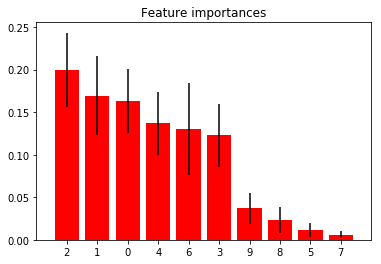

In [142]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [143]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf2.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9877707896575821

In [144]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9879681118610654

In [145]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.846890,1.000000,0.917098
Ducha,1.000000,0.994318,0.997151
Lavadora,0.994595,1.000000,0.997290
Aspiradora,1.000000,0.965714,0.982558
Afeitadora,1.000000,0.980892,0.990354
Secador_pelo,1.000000,0.983051,0.991453
Aire_acondicionado,1.000000,0.989071,0.994505
Telefono,1.000000,0.995798,0.997895
Tecleo,1.000000,0.958549,0.978836


Confusion matrix, without normalization
[[177   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 175   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 184   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0   1 169   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0 154   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0 174   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0 181   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0 237   0   0   0   0   0   0   0   0]
 [  7   0   0   0   0   0   0   0 185   0   0   0   0   1   0   0]
 [  1   0   0   0   0   0   0   0   0 177   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0 169   0   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0   0 192   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 174   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0 201   0   0]
 [  0   0   0   0   0 

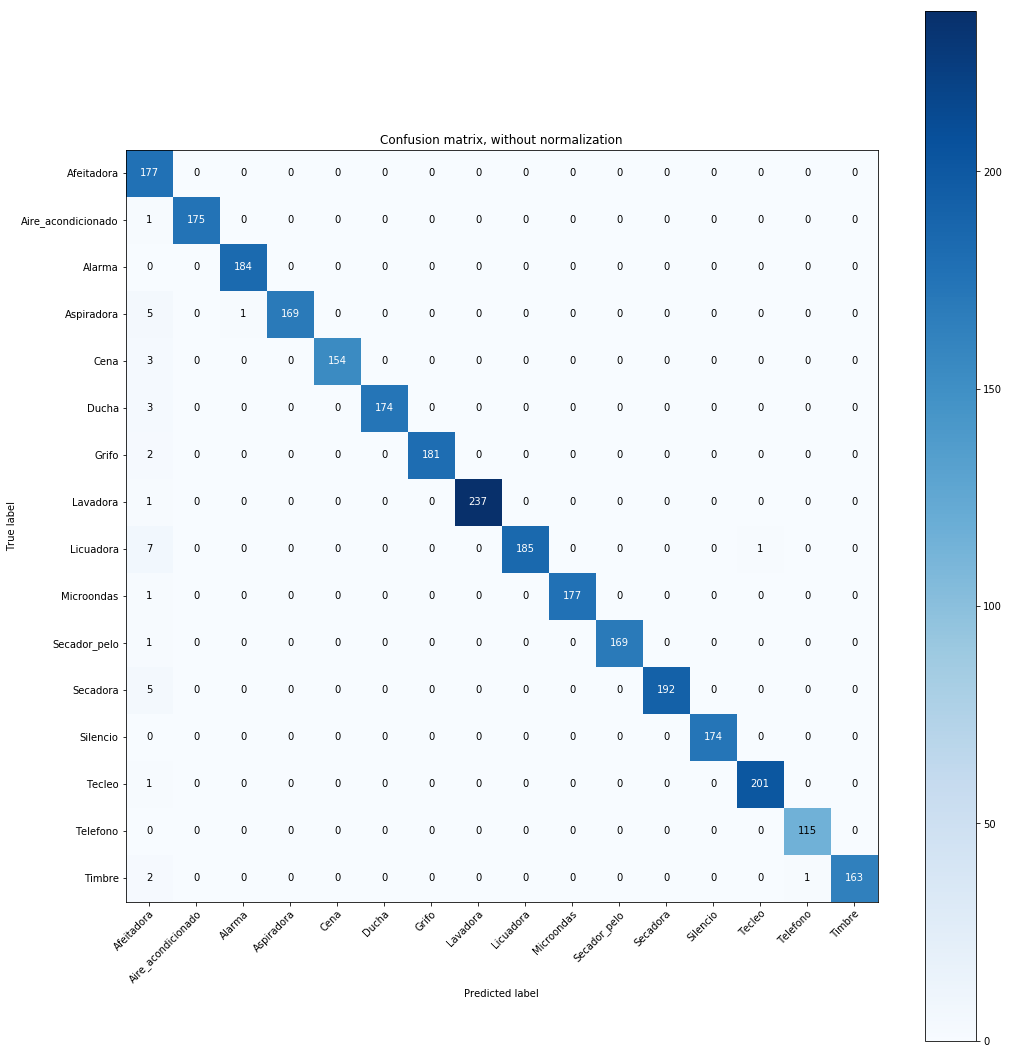

In [146]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [147]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [149]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [150]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [151]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [152]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [153]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [154]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

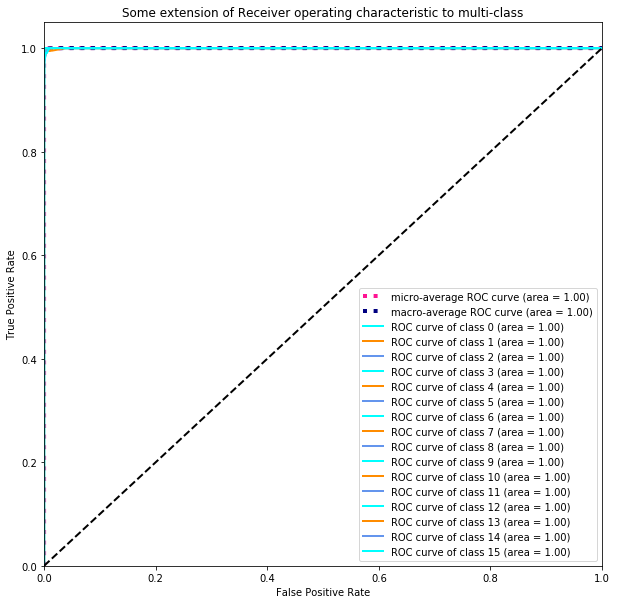

In [155]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# PCA - 8

In [156]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [157]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    theDataFrame = theDataFrame.drop(['Fourier18', 'Fourier19', 'Fourier20', 'Fourier21', 'Fourier22', 'Fourier23', 
                                      'Fourier24', 'Fourier25', 'Fourier26', 'Fourier27', 'Fourier28', 'Fourier29', 
                                      'Fourier30', 'Fourier31', 'Fourier32'], axis=1)
    return theDataFrame

data = readCsvToDataFrame('data_fourier.csv')

In [158]:
features = ['mfcc', 'scem','scom', 'srom','sbwm', 'tempo', 'rmse', 
            'Fourier1', 'Fourier2', 'Fourier3', 'Fourier4', 'Fourier5', 
            'Fourier6', 'Fourier7', 'Fourier8', 'Fourier9', 'Fourier10',
            'Fourier11', 'Fourier12', 'Fourier13', 'Fourier14', 'Fourier15',
            'Fourier16', 'Fourier17']

x = data.loc[:, features].values
y = data.loc[:,['momento']].values

x = StandardScaler().fit_transform(x)

In [159]:
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1',
                                      'principal component 2',
                                      'principal component 3',
                                      'principal component 4',
                                      'principal component 5',
                                      'principal component 6',
                                      'principal component 7',
                                      'principal component 8'])

principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8
0,-2.201574,-1.257220,-2.003313,-0.393063,1.421899,0.572673,-0.504228,1.556401
1,-1.000824,1.353943,-0.411408,0.098372,1.030078,-0.446073,-0.311209,-0.094352
2,2.765064,-3.227865,1.141361,0.153000,-1.216030,-0.158669,-1.415106,-0.818990
3,2.829244,1.997792,-0.731961,0.230611,-0.852097,-0.145343,0.588970,0.469515
4,0.195324,-2.737983,0.874723,-0.614378,-0.621843,0.150732,-0.025082,-0.134866


In [160]:
principalDf.reset_index(drop=True, inplace=True)

aux = data[['momento']]
aux.reset_index(drop=True, inplace=True)

finalDf = pd.concat([principalDf, aux], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,momento
0,-2.201574,-1.257220,-2.003313,-0.393063,1.421899,0.572673,-0.504228,1.556401,Timbre
1,-1.000824,1.353943,-0.411408,0.098372,1.030078,-0.446073,-0.311209,-0.094352,Cena
2,2.765064,-3.227865,1.141361,0.153000,-1.216030,-0.158669,-1.415106,-0.818990,Lavadora
3,2.829244,1.997792,-0.731961,0.230611,-0.852097,-0.145343,0.588970,0.469515,Secador_pelo
4,0.195324,-2.737983,0.874723,-0.614378,-0.621843,0.150732,-0.025082,-0.134866,Aire_acondicionado


In [161]:
print('La variación explicada por cada feature ha sido de {} respectivamente.'.format(pca.explained_variance_ratio_))
print('La variación explicada total de este modelo con respecto al original ha sido del {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_)*100))
print('La variación perdida con respecto al modelo original ha sido del {:.2f}%.'.format(100 - np.sum(pca.explained_variance_ratio_)*100))

La variación explicada por cada feature ha sido de [0.37255227 0.17250664 0.06712251 0.04584989 0.04115393 0.03485535
 0.03290346 0.02988434] respectivamente.
La variación explicada total de este modelo con respecto al original ha sido del 79.68%.
La variación perdida con respecto al modelo original ha sido del 20.32%.


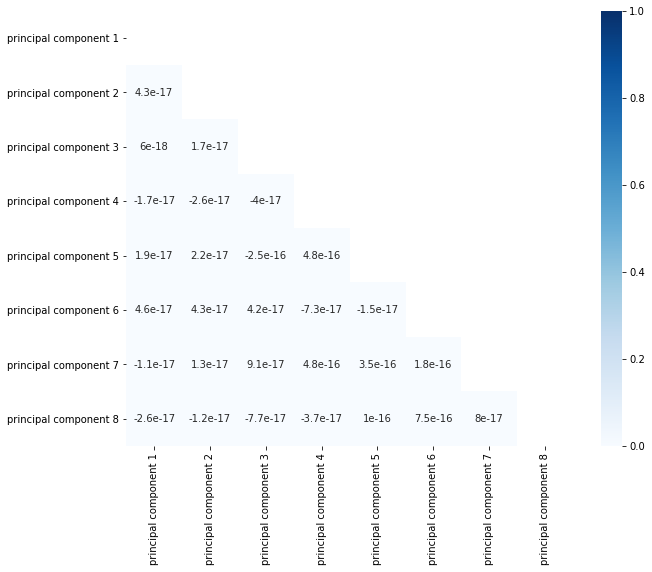

In [162]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

#     sns.set(style="ticks")
#     sns.pairplot(dataset, hue=classes)
    
get_matrix(finalDf, 'momento')

In [163]:
y = pd.get_dummies(data=finalDf.momento)
X = data.loc[:, finalDf.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [164]:
clf3 = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(clf3, X, y, cv=20)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.98743017 0.98882682 0.98044693 0.98882682 0.99441341 0.99162011
 0.98044693 0.99301676 0.97206704 0.98601399 0.99440559 0.99300699
 0.98741259 0.98881119 0.98181818 0.98461538 0.98461538 0.99020979
 0.98601399 0.98041958]
Accuracy: 0.99 (+/- 0.01)


In [168]:
clf3.fit(X_train, y_train)
clf3.score(X_test, y_test)

0.9870719776380154

In [169]:
predictions = clf3.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.0
Aire_acondicionado    0.0
Alarma                0.0
Aspiradora            0.0
Cena                  0.0
Ducha                 0.0
Grifo                 0.0
Lavadora              0.0
Licuadora             0.0
Microondas            0.0
Secador_pelo          0.0
Secadora              0.0
Silencio              0.0
Tecleo                0.0
Telefono              0.0
Timbre                0.0
dtype: float64 degrees.


In [170]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_

In [171]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

In [172]:
indices = np.argsort(importances)[::-1]

In [173]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.200116)
2. feature 0 (0.173107)
3. feature 1 (0.162094)
4. feature 4 (0.144973)
5. feature 6 (0.144149)
6. feature 3 (0.142540)
7. feature 7 (0.018702)
8. feature 5 (0.014319)


,importance
scom,0.200116
mfcc,0.173107
scem,0.162094
sbwm,0.144973
rmse,0.144149
srom,0.142540
Fourier1,0.018702
tempo,0.014319


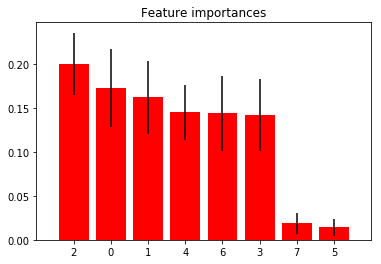

In [174]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [175]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf3.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9874213836477987

In [176]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9871300619916229

In [177]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.865217,1.000000,0.927739
Ducha,1.000000,1.000000,1.000000
Lavadora,1.000000,0.989744,0.994845
Aspiradora,1.000000,0.969880,0.984709
Afeitadora,1.000000,0.983471,0.991667
Secador_pelo,1.000000,0.994681,0.997333
Aire_acondicionado,1.000000,0.989583,0.994764
Telefono,1.000000,0.990698,0.995327
Tecleo,1.000000,0.980676,0.990244


Confusion matrix, without normalization
[[199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 181   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 193   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  4   0   0 161   0   0   0   0   0   0   0   0   0   0   1   0]
 [  2   0   0   0 119   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0 187   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0 190   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0 213   0   0   0   0   0   0   0   0]
 [  4   0   0   0   0   0   0   0 203   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0 182   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0 176   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0 169   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0 189   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0   0   0 208   0   0]
 [  1   0   0   0   0 

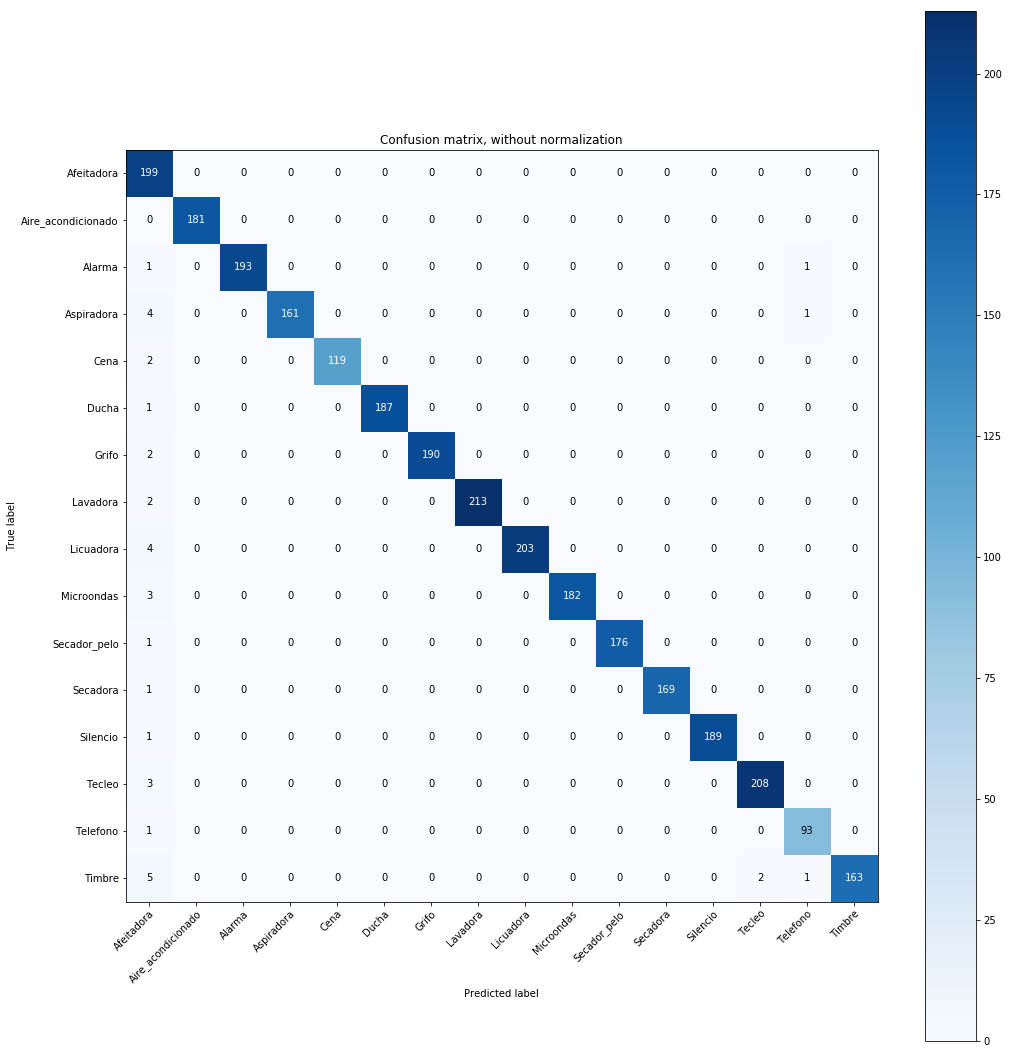

In [178]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [179]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [181]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [182]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [183]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [184]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [185]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [186]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

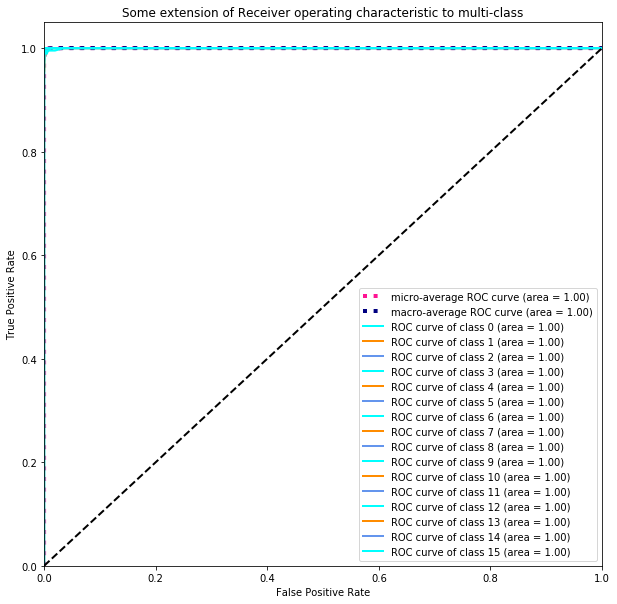

In [187]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Conclusiones

Como se ha podido observar en los diferentes resultados, tras aplicar los diferentes PCA no ha habido una mejora sustancial en la calidad de la regresión, los resultados han pasado de una precisión del 96% al 98% en el mejor de los casos.

Además habría que tener en cuenta la aleatoriedad a la hora de seleccionar el train set y test set. 

De todas formas, voy a predecir también con el modelo PCA de 10 features, para comprobar si las predicciones mejoran con respecto al modelo original.